In [42]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

import jax
sys.path.append(PRP)

from scripts.load_runtime import * #Setup parameters for veros 
from setups.acc.acc_learning import ACCSetup

from tqdm import tqdm

In [18]:
from functools import partial

# Spin-Up

In [ ]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()

with acc.state.variables.unlock() :
     acc.state.variables.r_bot += 1e-5
     acc.state.variables.K_gm_0 = 1000.0

def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 200/200 [00:06<00:00, 31.33it/s] 


# Compute derivative

In [60]:
acc.state.variables.r_bot

Array(1.e-05, dtype=float64)

In [61]:
class autodiff() :
    def __init__(self, step_function, agg_function,  var_name) :
        """
            Computes derivative dL/dvar with L in R and var in R
            step_function is the function done n iterations
            agg_function is computed at the end to go from R^space -> R
            var_name : name of the variable in the state to differentiatiat w.r.t
        """
        self.agg_function = agg_function
        self.step_function = partial(autodiff.pure, step=step_function)
        self.var_name = var_name

    @staticmethod
    def pure(state, step) :
        """
            Convert the state function into a "pure step" copying the input state
        """
        n_state = state.copy()
        step(n_state)  # This is a function that modifies state object inplace
        return n_state

    @staticmethod
    def set_var(var_name, state, var_value):
        n_state = state.copy()
        vs = n_state.variables
        with n_state.variables.unlock():
            setattr(vs, var_name, var_value)
        return n_state
    
    def rollout(self, n_state, iterations) :
        for _ in range(iterations):
                    n_state = self.step_function(n_state)
        return n_state

    def g(self, state, var_value, iterations=1, **kwargs):
        def loss_fn(v):
            # rollout for `iterations` steps
            n_state = autodiff.set_var(self.var_name, state, v)
            n_state = self.rollout(n_state, iterations)
            return self.agg_function(n_state)
    
        loss, grad = jax.value_and_grad(loss_fn)(var_value)
        return loss, grad

In [62]:
def agg_function(state) :
    return (state.variables.temp ** 2).sum()

var_dev = 'r_bot'
it = 2

In [63]:
vjpm_nr = autodiff(acc.step, agg_function, var_dev)

vjpm_nr.step_function = jax.jit(vjpm_nr.step_function)
vjpm_nr.agg_function = jax.jit(vjpm_nr.agg_function)

vjpm_nr.step_function = jax.checkpoint(vjpm_nr.step_function) # Remat to save memory


loss_and_grad_nr = lambda s, v, it: vjpm_nr.g(s, v, iterations=it)

In [64]:
loss_and_grad_nr(acc.state, 1e-5, 2)

(Array(6645090.47823557, dtype=float64),
 Array(2.28522461e-07, dtype=float64, weak_type=True))

# Parameter fitting experiment 

We try to fit a variable ("r_bot" or other) so that the state after it is similar to a target state. 

In [65]:
pred_iter = 5
targe_state = vjpm_nr.rollout(acc.state, iterations=pred_iter)
# We fix the target state iterating from the initial configuration

In [66]:
def agg_function(state) :
    return ((state.variables.temp - targe_state.variables.temp) ** 2).sum()

In [67]:
vjpm_nr = autodiff(acc.step, agg_function, var_dev)

vjpm_nr.step_function = jax.jit(vjpm_nr.step_function)
vjpm_nr.agg_function = jax.jit(vjpm_nr.agg_function)

vjpm_nr.step_function = jax.checkpoint(vjpm_nr.step_function) # Remat to save memory


loss_and_grad_nr = lambda s, v, it: vjpm_nr.g(s, v, iterations=it)

In [68]:
loss_and_grad_nr(acc.state, 0.0, pred_iter)

(Array(1.08265433e-05, dtype=float64),
 Array(-2.24704871, dtype=float64, weak_type=True))

In [80]:
import jax.numpy as jnp
from jax import vmap

In [77]:
r_bots = jnp.linspace(-4e-5, 4e-5, 10)

In [86]:
losses = []
grads = []
for rb in r_bots :
    loss, grad = loss_and_grad_nr(acc.state, rb, pred_iter)
    losses.append(loss)
    grads.append(grad)

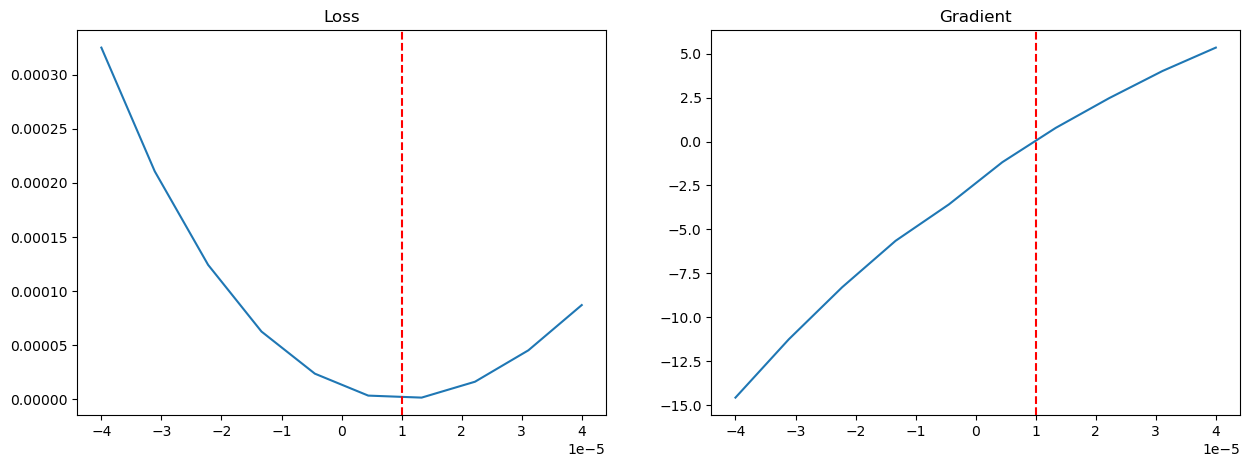

In [96]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].set_title('Loss')
axs[0].plot(r_bots, losses)
axs[0].axvline(acc.state.variables.r_bot, color='r', linestyle='dashed')
axs[1].set_title('Gradient')
axs[1].plot(r_bots, grads)
axs[1].axvline(acc.state.variables.r_bot, color='r', linestyle='dashed')